In [161]:
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('solarizedl')

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
from numpy.linalg import inv
from collections import OrderedDict
from operator import itemgetter
import string
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.naive_bayes import GaussianNB
import time

## Reading data from files, generating the target array, removing punctuations, and lower casing the tes

In [163]:
# Yelp train
str2 = open('IMDB-train.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpTrain  = ["" for x in range(size)]
yelpTrainY = np.zeros((size,1))
dictionary = {} #of words
for i in range(size):
    yelpTrain[i] = ' '.join(yelpTrain[i].split())
    yelpTrain[i]  = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpTrainY[i] = int(arr[i].split('\t')[1])
    tempStrArr = yelpTrain[i].split(' ')
    for j in range(len(tempStrArr)):
        if tempStrArr[j] !='':
            dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
print yelpTrainY.shape
##############################
# Yelp test
##############################
str2 = open('IMDB-test.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpTest  = ["" for x in range(size)]
yelpTestY = np.zeros((size,1))
for i in range(size):
    yelpTest[i] = ' '.join(yelpTest[i].split())
    yelpTest[i] = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpTestY[i] = int(arr[i].split('\t')[1])
#    tempStrArr = yelpTest[i].split(' ')
#    for j in range(len(tempStrArr)):
#        dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
##############################
# Yelp valid
##############################
str2 = open('IMDB-valid.txt', 'r').read()
arr = str2.split("\n")
size = len(arr)-1
yelpVal  = ["" for x in range(size)]
yelpValY = np.zeros((size,1))
for i in range(size):
    yelpVal[i] = ' '.join(yelpVal[i].split())
    yelpVal[i] = (arr[i].split('\t')[0]).translate(None, string.punctuation).lower()
    yelpValY[i] = int(arr[i].split('\t')[1])
#    tempStrArr = yelpVal[i].split(' ')
#    for j in range(len(tempStrArr)):
#        dictionary[tempStrArr[j]] = dictionary.get(tempStrArr[j],0) +1
yelpTrainY = yelpTrainY.astype(int)
yelpTestY  = yelpTestY.astype(int)
yelpValY   =  yelpValY.astype(int)
print yelpTrainY.shape
print yelpTestY.shape
print yelpValY.shape

(15000, 1)
(15000, 1)
(25000, 1)
(10000, 1)


In [169]:
features = sorted(dictionary, key=dictionary.get, reverse=True)
#print len(features)
features = features[:10000]
print len(features)

#print (features[:10000])
#for r in a1_sorted_keys[:100]:
#    print r, dictionary[r]

10000


## Generating 15Kx10K feature set 

In [165]:
datasetTrain = np.zeros((15000,10000),dtype=int)
for i in range(len(yelpTrain)):
    words = np.array((yelpTrain[i].split(' ')))
    for word in words:
        try:
            datasetTrain[i][features.index(word)] +=1; 
        except ValueError:
            j=0
print 'Done'

Done


In [166]:
datasetValid = np.zeros((10000,10000),dtype=int)
for i in range(len(yelpVal)):
    words = np.array((yelpVal[i].split(' ')))
    for word in words:
        try:
            datasetValid[i][features.index(word)] +=1; 
        except ValueError:
            j=0
print 'Done'

Done


In [167]:
datasetTest = np.zeros((25000,10000),dtype=int)
for i in range(len(yelpTest)):
    words = np.array((yelpTest[i].split(' ')))
    for word in words:
        try:
            datasetTest[i][features.index(word)] +=1; 
        except ValueError:
            j=0
print 'Done'

Done


In [168]:
print datasetTrain [3][:20]

[14 20  8  6 11 10  8  4  6  1  8  8  3  1  0  4  3  3  2  2]


In [114]:
#computing multi-class acc with https://sebastianraschka.com/faq/docs/multiclass-metric.html
def computeAccuracyMC(myY,Y,showResults,targets):
    confusionMatrix = np.zeros((len(targets),len(targets)),dtype=int)
    for i in range(len(myY)):
        a,b=  myY[i]-1,Y[i]-1
        confusionMatrix[a][b] +=1;
    Y = Y.reshape(Y.shape[0],1);
    TP =0
    P = len(Y);
    Accuracy  = np.zeros((len(targets)),dtype=float)
    Percision = np.zeros((len(targets)),dtype=float)
    Recall    = np.zeros((len(targets)),dtype=float)
    F1        = np.zeros((len(targets)),dtype=float)
    for i in range(len(targets)):
        TP = confusionMatrix[i][i]
        FP = np.sum(confusionMatrix, axis=1)[i] -TP
        FN = np.sum(confusionMatrix, axis=0)[i] -TP
        try:
            Accuracy[i]  = float((TP))/(TP+FP+FN)
        except ZeroDivisionError:
            Accuracy[i]=0
        try:
            Percision[i] = float(TP) / (TP+FP) 
        except ZeroDivisionError:
            Percision[i]=0
        try:
            Recall[i]    = float(TP) / (TP+FN) 
        except ZeroDivisionError:
            Recall[i] =0
        try:
            F1[i]    = float(2*TP) / (2*TP + FP + FN)
        except ZeroDivisionError:
            F1[i] =0
    if showResults:
        print "Confusion Matrix is: \n" , confusionMatrix 
        print "Accuracy is:\t", Accuracy, "avrg=",np.mean(Accuracy) 
        print "Percision is:\t", Percision, "avrg=", np.mean(Percision) 
        print "Recall is:\t", Recall, "avrg=", np.mean(Recall) 
        print "F1 score is:\t", F1, "avrg=", np.nanmean(F1)
    return [confusionMatrix,Accuracy,Percision,Recall,F1]

## Predicting random

In [116]:
#Random
myResult = np.random.randint(2, size=yelpTestY.shape[0]);
print myResult
targets= np.array(range(2))
computeAccuracyMC(myResult,yelpTestY,True,targets);
print f1_score(y_true=yelpTestY, y_pred=myResult, average='weighted')  

[0 0 0 ... 1 1 0]
Confusion Matrix is: 
[[6307 6227]
 [6193 6273]]
Accuracy is:	[0.33678646 0.33558016] avrg= 0.3361833108764276
Percision is:	[0.50319132 0.50320873] avrg= 0.5032000236750551
Recall is:	[0.50456 0.50184] avrg= 0.5032
F1 score is:	[0.50387473 0.50252343] avrg= 0.5031990811170204
0.5031990811170204


In [117]:
#Majority voting
#counts = np.zeros(5,dtype=int)
#for i in range(5):
#    counts[i] = (yelpTrainY==(i+1)).sum()
#print counts
#predictMajority = np.full((yelpTestY.shape[0]), np.argmax(counts)+1 , dtype=np.int)
#targets= np.array(range(5))+1
#computeAccuracyMC(predictMajority,yelpTestY,True,targets);
#print f1_score(y_true=yelpTestY, y_pred=predictMajority, average='weighted')  

In [121]:
binaryTrainDS = np.copy(datasetTrain);
binaryTrainDS[np.nonzero(binaryTrainDS)] =1

binaryValidDS = np.copy(datasetValid);
binaryValidDS[np.nonzero(binaryValidDS)] =1

binaryTestDS = np.copy(datasetTest);
binaryTestDS[np.nonzero(binaryTestDS)] =1

print binaryTrainDS[0][:20]
print datasetTrain[0][:20]

[1 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0]
[2 5 0 1 0 3 0 0 0 1 1 0 0 1 3 0 2 0 0 0]


In [122]:
print np.sum(freqTrainDS,axis=1)[0]
print np.sum(datasetTrain,axis=1)[0]

0.9999999999999999
47


In [123]:
def showResutlsTVT(X,Y,tags):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    ax.set_title(tags[0])
    plt.plot(X,Y[0],  label="F1 on Train")
    plt.plot(X,Y[1],  label="F1 on Validation")
    #plt.plot(X,Y[2],  label="F1 on Test")
    #plt.plot(range(Ks*scale),F1, label="F1 Score")
    ax.set_xlabel(tags[1])
    ax.set_ylabel('F1 value')
    ax.legend(loc='best')
    plt.show()

## Naive Bayes for binary

In [129]:
start_time = time.time()

# Bernoli Naive Bayes
alpha_NaivaB = np.linspace(0.2, 0.5, num=10)
size =alpha_NaivaB.shape[0]
F1_NaiveB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = BernoulliNB(alpha_NaivaB[i],0.5, True)
    clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_NaiveB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    #computeAccuracyMC(result,yelpValY,True,targets);
    F1_NaiveB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    #computeAccuracyMC(result,yelpTestY,True,targets);
    F1_NaiveB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
--- 56.6832439899 seconds ---


Train perfomance with best depth of valid-set is  0.30000000000000004 with value  0.8721680880414987
Max of F1 for validation set is 0.30000000000000004 with value  0.8427709189091614
Test perfomance with best C of valid-set is  0.30000000000000004 with value  0.8360948361459535


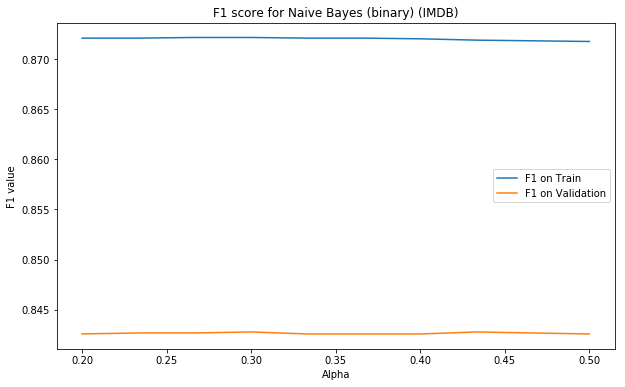

In [131]:
print "Train perfomance with best depth of valid-set is ", alpha_NaivaB[np.argmax(F1_NaiveB[1])], "with value ",F1_NaiveB[0][np.argmax(F1_NaiveB[1])]
print "Max of F1 for validation set is", alpha_NaivaB[np.argmax(F1_NaiveB[1])],"with value ",F1_NaiveB[1][np.argmax(F1_NaiveB[1])]
print "Test perfomance with best C of valid-set is ", alpha_NaivaB[np.argmax(F1_NaiveB[1])],"with value ",F1_NaiveB[2][np.argmax(F1_NaiveB[1])]
showResutlsTVT(alpha_NaivaB,F1_NaiveB,["F1 score for Naive Bayes (binary) (IMDB)","Alpha"])

In [132]:
freqTrainDS = np.copy(datasetTrain).astype(float)
temp = np.sum(freqTrainDS,axis=1)
for i in range(freqTrainDS.shape[0]):
    freqTrainDS[i]= freqTrainDS[i][:]/temp[i]

freqValidDS = np.copy(datasetValid).astype(float);
temp = np.sum(freqValidDS,axis=1)
for i in range(freqValidDS.shape[0]):
    freqValidDS[i] = freqValidDS[i][:]/temp[i]

freqTestDS = np.copy(datasetTest).astype(float);
temp = np.sum(freqTestDS,axis=1)
for i in range(freqTestDS.shape[0]):
    freqTestDS[i] = freqTestDS[i][:]/temp[i]

freqTrainDS[(np.isnan(freqTrainDS))] =0
freqValidDS[(np.isnan(freqValidDS))] =0
freqTestDS[(np.isnan(freqTestDS))]   =0

print 'Done...'

Done...


## Decision Tree for binary

In [130]:
clf = tree.DecisionTreeClassifier()
myTree = clf.fit(binaryTrainDS, yelpTrainY)
print myTree.tree_.max_depth
print myTree.tree_.max_n_classes
print myTree.tree_.capacity


115
2
3619


In [134]:
start_time = time.time()
depth_DTB = np.arange(5,112,5)
size =depth_DTB.shape[0]
F1_DTB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = tree.DecisionTreeClassifier(max_depth=depth_DTB[i])
    myTree = clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_DTB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    F1_DTB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    F1_DTB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

Max of F1 for training set is with depth 28 with value  0.9268916895399921
Max of F1 for validation set is with depth 16 with value  0.7186797188048392
Test perfomance with best C of valid-set is  16 with value  0.7261435437276282


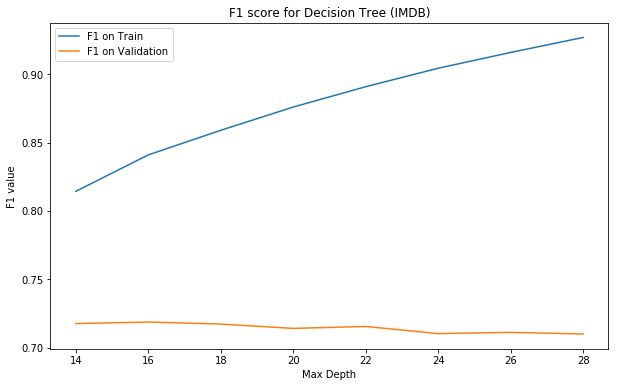

In [103]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", depth_DTB[np.argmax(F1_DTB[1])], "with value ",F1_DTB[0][np.argmax(F1_DTB[1])]
print "Max of F1 for validation set is with depth", depth_DTB[np.argmax(F1_DTB[1])],"with value ",F1_DTB[1][np.argmax(F1_DTB[1])]
print "Test perfomance with best C of valid-set is ", depth_DTB[np.argmax(F1_DTB[1])],"with value ",F1_DTB[2][np.argmax(F1_DTB[1])]
showResutlsTVT(depth_DTB,F1_DTB,["F1 score for Decision Tree (IMDB)","Max Depth"])

## Linear SVM for classification

In [157]:
start_time = time.time()
C_SVMB = np.linspace(0.001,0.01,num=20)
size =C_SVMB.shape[0]
F1_SVMB    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = LinearSVC(C=C_SVMB[i],dual=False)
    clf.fit(binaryTrainDS, yelpTrainY)
    result = clf.predict(binaryTrainDS);
    F1_SVMB[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(binaryValidDS);
    F1_SVMB[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(binaryTestDS);
    F1_SVMB[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
--- 33.1529049873 seconds ---


Train perfomance with best depth of valid-set is  0.004789473684210527 with value  0.9469305822147154
Max of F1 for validation set C = 0.004789473684210527 with value  0.8775913628465624
Test perfomance with best C of valid-set is  0.004789473684210527 with value  0.8756344505107044


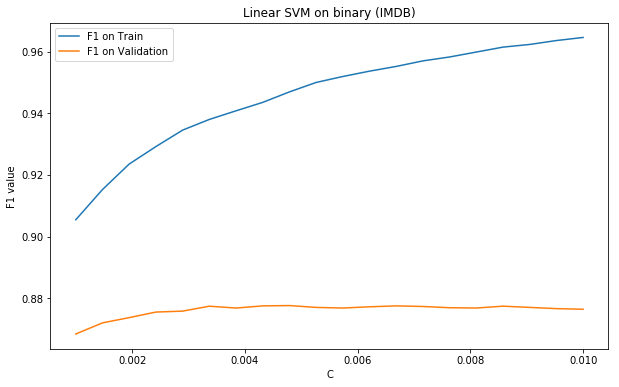

In [158]:

print "Train perfomance with best depth of valid-set is ", C_SVMB[np.argmax(F1_SVMB[1])], "with value ",F1_SVMB[0][np.argmax(F1_SVMB[1])]
print "Max of F1 for validation set C =", C_SVMB[np.argmax(F1_SVMB[1])],"with value ",F1_SVMB[1][np.argmax(F1_SVMB[1])]
print "Test perfomance with best C of valid-set is ", C_SVMB[np.argmax(F1_SVMB[1])],"with value ",F1_SVMB[2][np.argmax(F1_SVMB[1])]
showResutlsTVT(C_SVMB,F1_SVMB,["Linear SVM on binary (IMDB)","C"])

## Naive Bayes for frequency bagging

In [135]:
start_time = time.time()

# Gaussian Naive Bayes
F1_NBG    = np.zeros((3),dtype=float)
clf = GaussianNB()
clf.fit(freqTrainDS, yelpTrainY)
result = clf.predict(freqTrainDS);
F1_NBG[0] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
result = clf.predict(freqValidDS);
#computeAccuracyMC(result,yelpValY,True,targets);
F1_NBG[1] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
result = clf.predict(freqTestDS);
#computeAccuracyMC(result,yelpTestY,True,targets);
F1_NBG[2] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')
print("--- %s seconds ---" % (time.time() - start_time))

--- 6.66834688187 seconds ---


In [136]:
print 'F1 for training is ',F1_NBG[0]
print 'F1 for test is ',F1_NBG[1]
print 'F1 for validation is ',F1_NBG[2]

F1 for training is  0.8633600597372348
F1 for test is  0.761411986130284
F1 for validation is  0.6958516929958297


## Decision Tree for frequency

In [67]:
clf = tree.DecisionTreeClassifier()
myTree = clf.fit(freqTrainDS, yelpTrainY)
print myTree.tree_.max_depth
print myTree.tree_.max_n_classes
print myTree.tree_.capacity

89
2
2821


In [139]:
start_time = time.time()
depth_DTF = np.arange(10,20,2)
size =depth_DTF.shape[0]
F1_DTF    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = tree.DecisionTreeClassifier(max_depth=depth_DTF[i])
    myTree = clf.fit(freqTrainDS, yelpTrainY)
    result = clf.predict(freqTrainDS);
    F1_DTF[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(freqValidDS);
    F1_DTF[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(freqTestDS);
    F1_DTF[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
--- 98.5161118507 seconds ---


Train perfomance with best depth of valid-set is  12 with value  0.803176929658291
Max of F1 for validation set is with depth 12 with value  0.7190850485577256
Test perfomance with best depth of valid-set is  12 with value  0.7135572272263093


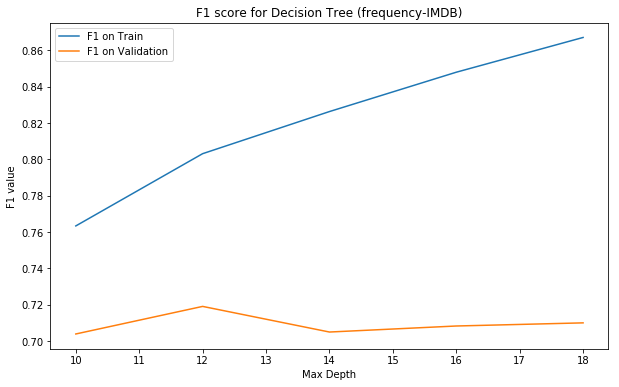

In [140]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", depth_DTF[np.argmax(F1_DTF[1])], "with value ",F1_DTF[0][np.argmax(F1_DTF[1])]
print "Max of F1 for validation set is with depth", depth_DTF[np.argmax(F1_DTF[1])],"with value ",F1_DTF[1][np.argmax(F1_DTF[1])]
print "Test perfomance with best depth of valid-set is ", depth_DTF[np.argmax(F1_DTF[1])],"with value ",F1_DTF[2][np.argmax(F1_DTF[1])]
showResutlsTVT(depth_DTF,F1_DTF,["F1 score for Decision Tree (frequency-IMDB)","Max Depth"])

## Linear SVM for frequency

In [143]:
start_time = time.time()
C_SVMF = np.linspace(30, 150, num=20)
size =C_SVMF.shape[0]
F1_SVMF    = np.zeros((3,size),dtype=float)
for i in range(size):
    clf = LinearSVC(C=C_SVMF[i],dual=False)
    clf.fit(freqTrainDS, yelpTrainY)
    result = clf.predict(freqTrainDS);
    F1_SVMF[0][i] = f1_score(y_true=yelpTrainY, y_pred=result, average='macro')  
    result = clf.predict(freqValidDS);
    F1_SVMF[1][i] = f1_score(y_true=yelpValY, y_pred=result, average='macro')  
    result = clf.predict(freqTestDS);
    F1_SVMF[2][i] = f1_score(y_true=yelpTestY, y_pred=result, average='macro')  
    print i
print("--- %s seconds ---" % (time.time() - start_time))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
--- 30.3598079681 seconds ---


Train perfomance with best depth of valid-set is  86.84210526315789 with value  0.9431989659687317
Max of F1 for validation set, C is 86.84210526315789 with value  0.879690893803752
Test perfomance with best C of valid-set is  86.84210526315789 with value  0.8750787525863919


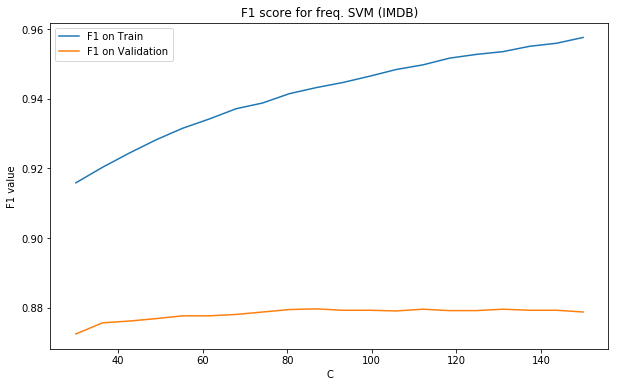

In [144]:
#print 'The depth of the tree is ',myTree.tree_.max_depth
print "Train perfomance with best depth of valid-set is ", C_SVMF[np.argmax(F1_SVMF[1])], "with value ",F1_SVMF[0][np.argmax(F1_SVMF[1])]
print "Max of F1 for validation set, C is", C_SVMF[np.argmax(F1_SVMF[1])],"with value ",F1_SVMF[1][np.argmax(F1_SVMF[1])]
print "Test perfomance with best C of valid-set is ", C_SVMF[np.argmax(F1_SVMF[1])],"with value ",F1_SVMF[2][np.argmax(F1_SVMF[1])]

showResutlsTVT(C_SVMF,F1_SVMF,["F1 score for freq. SVM (IMDB)","C"])

## Submitting dataset

In [170]:
## vocab.txt
a1_sorted_keys = sorted(features, key=dictionary.get, reverse=True)
counter =1
file = open("./myFiles/IMDB-vocab.txt","w") 
for r in a1_sorted_keys:
    text = str(r) + '\t' + str(counter) + '\t' + str(dictionary[r]) + '\n'
    file.write(text)  
    counter+=1
print 'Done...'


Done...


In [160]:
def writeFiles(Name,ds,ds_y,features):
    file = open("myFiles/"+Name,"w") 
    for i in range(len(ds)):
        words = np.array((ds[i].split(' ')))
        text = ""
        for word in words:
            try:
                text += str(features.index(word)) + ' '
                #print word,features.index(word)
            except ValueError:
                text 
        text  += '\t' + str(ds_y[i][0]) + '\n'
        file.write(text)
    print 'Done...'

writeFiles("IMDB-train.txt",yelpTrain,yelpTrainY,features)
writeFiles("IMDB-valid.txt",yelpVal,yelpValY,features)
writeFiles("IMDB-test.txt",yelpTest,yelpTestY,features)

Done...
Done...
Done...
